<a href="https://colab.research.google.com/github/chris-kehl/kentucky_tree_classifier/blob/main/Trees_of_Kentucky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the needed packages to start the fastAi packages

In [1]:
# import all the needed starter packages
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.3MB/s 
     |████████████████████████████████| 1.2MB 54.9MB/s 
     |████████████████████████████████| 204kB 51.9MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 61kB 11.3MB/s 
     |████████████████████████████████| 61kB 11.9MB/s 
Mounted at /content/gdrive


In [2]:
# import fastbook
from fastbook import *
from fastai.vision.widgets import *
import os

In [3]:
os.getcwd()

'/content'

In [4]:
os.chdir('/content/gdrive/MyDrive/')

In [5]:
os.getcwd()

'/content/gdrive/My Drive'

Setup Microsoft Bing keys used to scrape the web for Kentucky tree 
images

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '8d45d7506c8e4e78ad0804f1dbea420f')

In [ ]:
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
results = search_images_bing(key, 'Arkansas Pine')
ims = results.attrgot('content_url')
len(ims)

150

In [ ]:
ims = ['https://i.pinimg.com/736x/38/ab/5d/38ab5d69effb4d06f7e13c416701e30d.jpg']

In [ ]:
dest = 'arkansas_pine.jpg'
download_url(ims[0], dest)

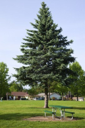

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

Setup folders and directories to hold the different types of KY native trees

In [ ]:
tree_types = 'ALLEGHENY SERVICEBERRY', 'AMERICAN BEECH', 'AMERICAN HOLLY', 'AMERICAN HOPHORNBEAM', 'AMERICAN HORNBEAM', 'AMERICAN LINDEN', 'BIGLEAF MAGNOLIA','BLACK CHERRY', 'BLACK LOCUST', 'BLACK OAK', 'BLACK WALNUT', 'BLACK GUM', 'BLUE ASH', 'BUR OAK', 'CHESTNUT OAK','CHINKAPIN OAK', 'COCKSPUR HAWTHORN', 'COMMON WITCHHAZEL','CUCUMBERTREE MAGNOLIA', 'DOWNY SERVICEBERRY', 'CANADIAN HEMLOCK', 'FLOWERING DOGWOOD','EASTERN HEMLOCK', 'BALD CYPRESS', 'SHELLBARK HICKORY', 'BUR OAK', 'BLACK OAK', 'EASTERN REDCEDAR', 'NORTHERN WHITE CEDAR', 'RED OAK', 'WHITE FRINGETREE', 'GREEN HAWTHORN', 'GREEN ASH', 'HONEYLOCUST', 'KENTUCKY COFFEETREE', 'CAROLINA SILVERBELL', 'MOUNTAIN STEWARTIA', 'EASTERN WHITE PINE', 'PITCH PINE', 'SHORTLEAF PINE', 'VIRGINIA PINE', 'LOBLOLLY PINE', 'STRIPED MAPLE', 'ASH', 'OHIO BUCKEYE', 'NORTHERN CATALPA', 'EASTERN REDBUD', 'MOUNTAIN MAPLE', 'NORWAY MAPLE', 'SUGAR MAPLE', 'BLACK MAPLE', 'PAGODA DOGWOOD','PAWPAW', 'PECAN', 'PERSIMMON', 'PIGNUT HICKORY', 'PIN OAK', 'RED BUCKEYE', 'RED MAPLE', 'RIVER BIRCH', 'SASSAFRAS','SCARLET OAK', 'SHAGBARK HICKORY', 'SHINGLE OAK', 'SOURWOOD', 'SUGAR HACKBERRY', 'SUGAR MAPLE', 'SWEET BIRCH', 'SWEETGUM', 'SYCAMORE', 'TULIP POPLAR', 'UMRRELLA MAGNOLIA', 'VIRGINIA PINE', 'WHITE ASH', 'WHITE OAK', 'WILLOW OAK', 'YELLOW BUCKEYE', 'YELLOWWOOD'

path = Path('trees')


In [ ]:
if not path.exists():
  path.mkdir()
  for o in tree_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} tree')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#9809) [Path('trees/arkansas_pine.jpg'),Path('trees/ALLEGHENY SERVICEBERRY/00000002.jpg'),Path('trees/ALLEGHENY SERVICEBERRY/00000003.jpg'),Path('trees/ALLEGHENY SERVICEBERRY/00000004.jpg'),Path('trees/ALLEGHENY SERVICEBERRY/00000000.JPG'),Path('trees/ALLEGHENY SERVICEBERRY/00000011.jpg'),Path('trees/ALLEGHENY SERVICEBERRY/00000012.jpg'),Path('trees/ALLEGHENY SERVICEBERRY/00000013.jpg'),Path('trees/ALLEGHENY SERVICEBERRY/00000016.jpg'),Path('trees/ALLEGHENY SERVICEBERRY/00000009.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
#remove failed files
failed.map(Path.unlink);

Format the downloaded data into a format that is suitable for model training. Fastai uses dataloaders


In [ ]:
class DataLoaders(GetAttr):
  def __init(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train, valid = add_props(lambda i,self: self[i])

In [ ]:
# were using the splitter here to split the data 80% training set and 20% test set
trees = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

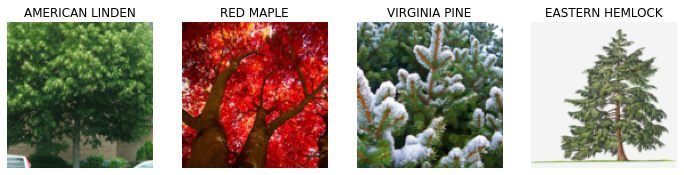

In [ ]:
dls = trees.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

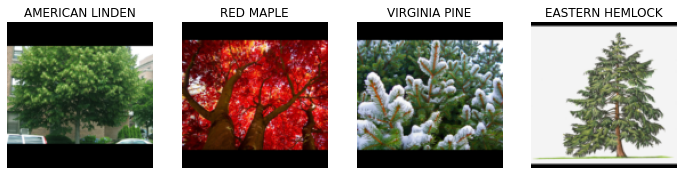

In [ ]:
# resize the images to make them square (128)
trees = trees.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = trees.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

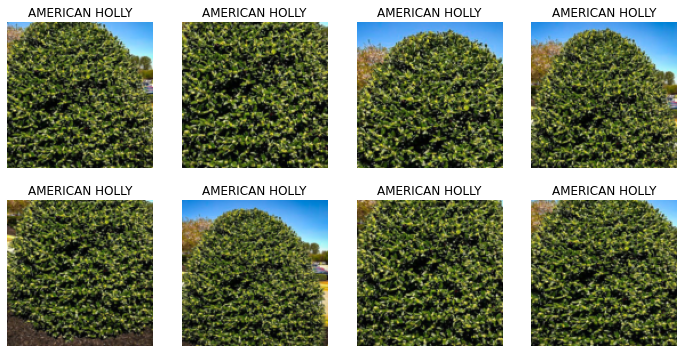

In [ ]:
trees = trees.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = trees.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Augmentation: flip, rotate, change contrast, brightness, etc

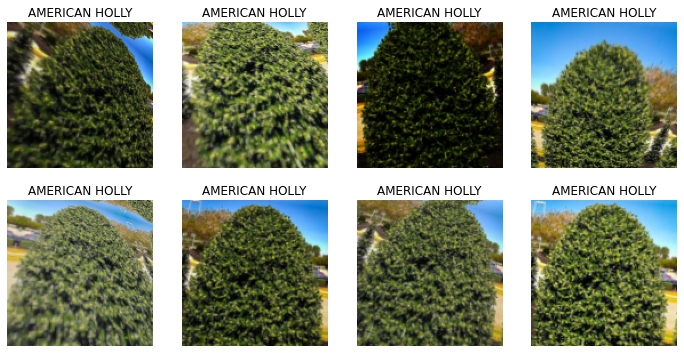

In [ ]:
trees = trees.new(item_tfms=Resize(128),
batch_tfms=aug_transforms(mult=2))
dls = trees.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Clean the data and Train the model 


In [ ]:
trees = trees.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
batch_tfms=aug_transforms())
dls = trees.dataloaders(path)                 

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(75)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,5.050228,3.716394,0.830699,02:23


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

epoch,train_loss,valid_loss,error_rate,time
0,3.929374,3.334387,0.787863,02:25
1,3.571734,3.143481,0.756247,02:26
2,3.331048,3.008419,0.729220,02:26
3,3.070348,2.898306,0.709842,02:26
4,2.823795,2.817029,0.696583,02:26
5,2.671202,2.753313,0.670576,02:26
6,2.458283,2.710812,0.672616,02:26
7,2.304869,2.673337,0.645589,02:26
8,2.138160,2.620304,0.642019,02:27
9,2.006067,2.626543,0.628761,02:26


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


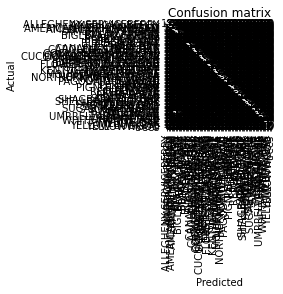

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

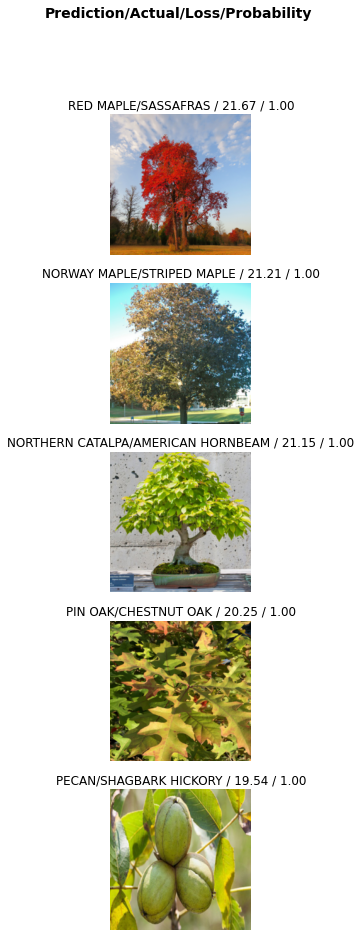

In [ ]:
interp.plot_top_losses(5, nrows=5)

In [ ]:
# Add the cleaner to clean up images that don't belong
#cleaner = ImageClassifierCleaner(learn)
#cleaner

In [ ]:
#for idx in cleaner.delete():
  #cleaner.fns[idx].unlink()


In [ ]:
#for idx,cat in cleaner.change():
  #shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [6]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [7]:
# Add a program that loads the learner and allows the user to select a photo of a tree to upload.

# load the learner
learn_inf = load_learner('/content/gdrive/MyDrive/export.pkl')

In [8]:
# make prediction and show tensors
# all of these numbers below are the tensors for each class of trees
learn_inf.predict('/content/gdrive/MyDrive/arkansas_pine.jpg')

('trees',
 tensor(74),
 tensor([2.8398e-09, 4.7535e-11, 2.3177e-08, 3.0370e-07, 1.5732e-07, 1.6741e-07, 3.2181e-10, 9.1391e-07, 2.1983e-12, 2.1525e-09, 1.0721e-09, 2.4408e-10, 1.3090e-11, 6.4929e-13, 8.4839e-11, 4.1315e-16,
         4.3226e-11, 2.9144e-08, 4.8534e-09, 1.0207e-09, 1.4516e-08, 2.3772e-08, 1.0832e-09, 1.7758e-10, 7.5003e-10, 6.6174e-08, 1.8096e-08, 5.9628e-09, 2.3643e-06, 2.8589e-07, 1.3116e-09, 2.1507e-10,
         5.1048e-09, 9.8224e-12, 1.8543e-07, 8.0590e-12, 9.6248e-12, 1.1991e-10, 3.7814e-13, 5.5652e-10, 1.3437e-10, 9.0373e-09, 3.5310e-08, 2.4177e-07, 1.5295e-11, 4.3249e-11, 7.1883e-07, 8.9953e-11,
         9.9536e-09, 1.4901e-11, 6.6400e-09, 9.3361e-12, 7.6456e-09, 2.0858e-10, 2.2748e-12, 4.3603e-13, 5.3639e-10, 2.2318e-07, 2.2984e-11, 2.4171e-10, 5.8368e-10, 1.8610e-13, 4.1042e-10, 1.8999e-10,
         9.5170e-08, 6.9407e-11, 2.1791e-12, 7.0786e-09, 1.1151e-11, 3.9924e-11, 1.2319e-11, 4.2491e-07, 6.7807e-11, 1.9445e-06, 9.9999e-01]))

In [9]:
# pulls out all the names of the tree types we have labels for
# this is called mapping, we are showing all of the mapping for the tensors
# the activation for all the trees are listed above. so Allegheny Serviceberry is 2.8398e-09.
learn_inf.dls.vocab

['ALLEGHENY SERVICEBERRY', 'AMERICAN BEECH', 'AMERICAN HOLLY', 'AMERICAN HOPHORNBEAM', 'AMERICAN HORNBEAM', 'AMERICAN LINDEN', 'ASH', 'BALD CYPRESS', 'BIGLEAF MAGNOLIA', 'BLACK CHERRY', 'BLACK GUM', 'BLACK LOCUST', 'BLACK MAPLE', 'BLACK OAK', 'BLACK WALNUT', 'BLUE ASH', 'BUR OAK', 'CANADIAN HEMLOCK', 'CAROLINA SILVERBELL', 'CHESTNUT OAK', 'CHINKAPIN OAK', 'COCKSPUR HAWTHORN', 'COMMON WITCHHAZEL', 'CUCUMBERTREE MAGNOLIA', 'DOWNY SERVICEBERRY', 'EASTERN HEMLOCK', 'EASTERN REDBUD', 'EASTERN REDCEDAR', 'EASTERN WHITE PINE', 'FLOWERING DOGWOOD', 'GREEN ASH', 'GREEN HAWTHORN', 'HONEYLOCUST', 'KENTUCKY COFFEETREE', 'LOBLOLLY PINE', 'MOUNTAIN MAPLE', 'MOUNTAIN STEWARTIA', 'NORTHERN CATALPA', 'NORTHERN WHITE CEDAR', 'NORWAY MAPLE', 'OHIO BUCKEYE', 'PAGODA DOGWOOD', 'PAWPAW', 'PECAN', 'PERSIMMON', 'PIGNUT HICKORY', 'PIN OAK', 'PITCH PINE', 'RED BUCKEYE', 'RED MAPLE', 'RED OAK', 'RIVER BIRCH', 'SASSAFRAS', 'SCARLET OAK', 'SHAGBARK HICKORY', 'SHELLBARK HICKORY', 'SHINGLE OAK', 'SHORTLEAF PINE', 'S

In [15]:
# select the upload button and select a tree
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [16]:
# get the image from the upload, display size 128,128
img = PILImage.create(btn_upload.data[-1])

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [17]:
# Make prediction based on the uploaded photo
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Predictions: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Predictions: PAGODA DOGWOOD; Probability: 0.6172')